In [1]:
#!/usr/bin/env python
from math import ceil
from random import uniform
import argparse
import os

import tensorflow as tf

from adain.nn import build_vgg, vgg_layer_params, build_decoder
from adain.norm import adain
from adain.util import get_params
from adain.weights import open_weights

import numpy as np
import numpy as np
import numba
from numba import njit, prange
from numba import cuda
import copy
import sys
import time
import matplotlib.pyplot as plt
import pydicom
import glob

from skimage.measure import label
from scipy.io import loadmat
from scipy.ndimage import zoom
#from scipy.misc import imresize
import pywt

import csv
import random
import time
%matplotlib inline  

from scipy import ndimage, misc

import pywt
#import hdf5storage

import scipy.io as sio
from skimage.filters import threshold_otsu


In [118]:
# Train Code

x_array = np.load("x_array.npy")
y_array = np.load("y_array.npy")

def get_my_batch():
    global x_array, y_array
    
    perm    = np.random.permutation(len(x_array))
    x_array = np.array(x_array)[perm]
    y_array = np.array(y_array)[perm]
    
    content_images = []
    style_images   = []
    
    for i in range(8):
        temp = [x_array[i, :, :, 0], x_array[i, :, :, 0], x_array[i, :, :, 0]]
        content_images.append(temp)
        
        temp = [y_array[i, :, :, 0], y_array[i, :, :, 0], y_array[i, :, :, 0]]
        style_images.append(temp)
       
    #content_images = x_array[:8, :, :, 0]
    #style_images   = y_array[:8, :, :, 0]
    
    #content_images = np.concatenate([content_images, content_images, content_images], axis=-1)
    #style_images   = np.concatenate([style_images, style_images, style_images], axis=-1)
    
    return np.array(content_images)*5, np.array(style_images)*5
    

def train(
        content_dir='datasets/coco',
        style_dir='datasets/wikiart',
        checkpoint_dir='checkpoints',
        decoder_activation='relu',
        initial_size=512,
        random_crop_size=256,
        resume=False,
        optimizer='adam',
        learning_rate=1e-5,
        learning_rate_decay=0,#5e-5,
        momentum=0.9,
        batch_size=8,
        num_epochs=16,
        content_layer='conv4_1',
        style_layers='conv1_1,conv2_1,conv3_1,conv4_1',
        tv_weight=0,
        style_weight=0.1,
        content_weight=1,
        save_every=2000,
        print_every=10,
        gpu=0,
        vgg='models/vgg19_weights_normalized.h5'):
    
    tf.reset_default_graph()
    #assert initial_size >= random_crop_size, 'Images are too small to be cropped'
    #assert gpu >= 0, 'CPU mode is not supported'

    #os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)
    
    #if not os.path.exists(checkpoint_dir):
    #    print('Creating checkpoint dir at', checkpoint_dir)
    #    os.mkdir(checkpoint_dir)

    style_layers = style_layers.split(',')
    
    # the content layer is also used as the encoder layer
    encoder_layer = content_layer
    encoder_layer_filters = vgg_layer_params(encoder_layer)['filters']
    encoder_layer_shape = (None, encoder_layer_filters, None, None)


    # decoder->encoder setup
    if decoder_activation == 'relu':
        decoder_activation = tf.nn.relu
    elif decoder_activation == 'elu':
        decoder_activation = tf.nn.elu
    else:
        raise ValueError('Unknown activation: ' + decoder_activation)
    
    input_image_shape = (None, 3, 128, 128)
    
    for_mae_loss    = tf.placeholder(tf.float32, shape=input_image_shape)
    
    content_encoded = tf.placeholder(tf.float32, shape=encoder_layer_shape)
    style_encoded   = tf.placeholder(tf.float32, shape=encoder_layer_shape)
    output_encoded  = adain(content_encoded, style_encoded)
    
    images = build_decoder(output_encoded, weights=None, trainable=True,
        activation=decoder_activation)
    
    #print(images, tf.shape(images))
    #return
    
    with open_weights(vgg) as w:
        vgg     = build_vgg(images, w, last_layer=encoder_layer)
        encoder = vgg[encoder_layer]


    # loss setup
    # content_target, style_targets will hold activations of content and style
    # images respectively
    content_layer  = vgg[content_layer]
    content_target = tf.placeholder(tf.float32, shape=encoder_layer_shape)
    
    style_layers = {layer: vgg[layer] for layer in style_layers}
    style_targets = {
        layer: tf.placeholder(tf.float32, shape=style_layers[layer].shape)
        for layer in style_layers
    }

    content_loss = build_content_loss(content_layer, content_target, content_weight)
    style_losses = build_style_losses(style_layers, style_targets, style_weight)
    
    loss = content_loss + tf.reduce_sum(list(style_losses.values()))
    
    #loss = loss + tf.losses.mean_absolute_error(images)
    
    if tv_weight:
        tv_loss = tf.reduce_sum(tf.image.total_variation(images)) * tv_weight
    else:
        tv_loss = tf.constant(0, dtype=tf.float32)
    loss += tv_loss
    
    mae_loss = tf.reduce_sum(tf.keras.losses.mean_absolute_error(for_mae_loss, images))
    loss    += mae_loss 

    # training setup
    #batch = setup_input_pipeline(content_dir, style_dir, batch_size,
    #    num_epochs, initial_size, random_crop_size)

    global_step = tf.Variable(0, trainable=False, name='global_step')
    rate = tf.train.inverse_time_decay(learning_rate, global_step,
        decay_steps=1, decay_rate=learning_rate_decay)

    if optimizer == 'adam':
        optimizer = tf.train.AdamOptimizer(rate, beta1=momentum)
    elif optimizer == 'sgd':
        optimizer = tf.train.GradientDescentOptimizer(rate)
    else:
        raise ValueError('Unknown optimizer: ' + optimizer)

    train_op = optimizer.minimize(loss, global_step=global_step)

    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.local_variables_initializer())

        if resume:
            latest = tf.train.latest_checkpoint(checkpoint_dir)
            saver.restore(sess, latest)
        else:
            sess.run(tf.global_variables_initializer())

        coord   = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess=sess, coord=coord)

        with coord.stop_on_exception():
            while not coord.should_stop():
                content_batch, style_batch = get_my_batch()
                #content_batch, style_batch = sess.run(batch)

                # step 1
                # encode content and style images,
                # compute target style activations,
                # run content and style through AdaIN
                content_batch_encoded = sess.run(encoder, feed_dict={
                    images: content_batch
                })

                style_batch_encoded, style_target_vals = sess.run([encoder, style_layers], feed_dict={
                    images: style_batch
                })

                output_batch_encoded = sess.run(output_encoded, feed_dict={
                    content_encoded: content_batch_encoded,
                    style_encoded: style_batch_encoded
                })

                # step 2
                # run the output batch through the decoder, compute loss
                feed_dict = {
                    output_encoded: output_batch_encoded,
                    # "We use the AdaIN output as the content target, instead of
                    # the commonly used feature responses of the content image"
                    content_target: output_batch_encoded
                }
                for layer in style_targets:
                    feed_dict[style_targets[layer]] = style_target_vals[layer]
                
                feed_dict[for_mae_loss] = style_batch
                
                allkeys = feed_dict.keys()
                #print("All keys are")
                #for kt in allkeys:
                #    print(kt)
                #print()
                #return 0, 1, 2
                
                fetches = [train_op, loss, content_loss, style_losses, tv_loss, global_step, mae_loss, images]
                result  = sess.run(fetches, feed_dict=feed_dict)
                _, loss_val, content_loss_val, style_loss_vals, tv_loss_val, i, mae_loss_val, output_result = result
                
                #print("MAE loss is ", mae_loss_val)
                
                if i % print_every == 0:
                    style_loss_val  = sum(style_loss_vals.values())
                    style_loss_vals = '\t'.join(sorted(['%s = %0.4f' % (name, val) for name, val in style_loss_vals.items()]))
                    print(i,
                        'loss = %0.4f' % loss_val,
                        'content = %0.4f' % content_loss_val,
                        'style = %0.4f' % style_loss_val,
                        style_loss_vals,
                        'tv = %0.4f' % tv_loss_val, sep='\t')
                    #print(output_result.shape, np.mean(output_result), np.mean(content_batch), np.mean(style_batch))

                if i % save_every == 0:
                    print('Saving checkpoint')
                    saver.save(sess, os.path.join(checkpoint_dir, 'adain'), global_step=i)

        coord.join(threads)
        saver.save(sess, os.path.join(checkpoint_dir, 'adain-final'))


def build_content_loss(current, target, weight):
    loss = tf.reduce_mean(tf.squared_difference(current, target))
    loss *= weight
    return loss


def build_style_losses(current_layers, target_layers, weight, epsilon=1e-6):
    losses = {}
    for layer in current_layers:
        current, target = current_layers[layer], target_layers[layer]

        current_mean, current_var = tf.nn.moments(current, axes=[2,3], keep_dims=True)
        current_std = tf.sqrt(current_var + epsilon)

        target_mean, target_var = tf.nn.moments(target, axes=[2,3], keep_dims=True)
        target_std = tf.sqrt(target_var + epsilon)

        mean_loss = tf.reduce_sum(tf.squared_difference(current_mean, target_mean))
        std_loss = tf.reduce_sum(tf.squared_difference(current_std, target_std))

        # normalize w.r.t batch size
        n = tf.cast(tf.shape(current)[0], dtype=tf.float32)
        mean_loss /= n
        std_loss /= n

        losses[layer] = (mean_loss + std_loss) * weight
    return losses



In [117]:
train()

MAE loss is  1453.5488
MAE loss is  1398.1351
MAE loss is  1244.1577
MAE loss is  1399.4996
MAE loss is  1504.1095
MAE loss is  1280.0573
MAE loss is  1426.1653
MAE loss is  1445.4202
MAE loss is  1348.4393
MAE loss is  1400.0212
10	loss = 1530.8577	content = 1.2129	style = 129.6235	conv1_1 = 10.1994	conv2_1 = 30.2323	conv3_1 = 27.0915	conv4_1 = 62.1003	tv = 0.0000
(8, 3, 128, 128) 0.0001511002 0.4556 0.4558
MAE loss is  1294.3838
MAE loss is  1279.2307
MAE loss is  1331.7932
MAE loss is  1396.07
MAE loss is  1334.3828
MAE loss is  1410.766
MAE loss is  1287.829
MAE loss is  1366.845
MAE loss is  1418.3966
MAE loss is  1431.9178
20	loss = 1586.8667	content = 1.4261	style = 153.5228	conv1_1 = 11.7447	conv2_1 = 31.7400	conv3_1 = 37.0518	conv4_1 = 72.9863	tv = 0.0000
(8, 3, 128, 128) 0.00050338765 0.4658 0.4666
MAE loss is  1405.5829
MAE loss is  1296.3142
MAE loss is  1426.3647
MAE loss is  1401.744
MAE loss is  1370.4683
MAE loss is  1410.3594
MAE loss is  1464.2493
MAE loss is  1361.37

MAE loss is  213.82326
MAE loss is  264.94067
MAE loss is  242.3629
MAE loss is  202.41344
210	loss = 220.0313	content = 0.2324	style = 17.3854	conv1_1 = 0.6268	conv2_1 = 1.2114	conv3_1 = 7.0212	conv4_1 = 8.5261	tv = 0.0000
(8, 3, 128, 128) 0.42758927 0.456 0.457
MAE loss is  216.74223
MAE loss is  166.22939
MAE loss is  152.0413
MAE loss is  173.7604
MAE loss is  207.35667
MAE loss is  182.47346
MAE loss is  193.49219
MAE loss is  282.3621
MAE loss is  127.06497
MAE loss is  124.44385
220	loss = 132.6833	content = 0.0970	style = 8.1424	conv1_1 = 0.1223	conv2_1 = 0.2551	conv3_1 = 3.9935	conv4_1 = 3.7715	tv = 0.0000
(8, 3, 128, 128) 0.45055103 0.4631 0.4634
MAE loss is  237.18129
MAE loss is  156.76773
MAE loss is  141.78323
MAE loss is  218.4144
MAE loss is  202.908
MAE loss is  212.94977
MAE loss is  191.4735
MAE loss is  237.97836
MAE loss is  182.838
MAE loss is  149.60744
230	loss = 159.4536	content = 0.1139	style = 9.7323	conv1_1 = 0.1895	conv2_1 = 0.4127	conv3_1 = 4.5917	conv4_1 

KeyboardInterrupt: 

In [97]:
# Transfer Style Code Test Code

x_array = np.load("x_array.npy")
y_array = np.load("y_array.npy")


def test(
        content_dir='datasets/coco',
        style_dir='datasets/wikiart',
        checkpoint_dir='checkpoints',
        decoder_activation='relu',
        initial_size=512,
        random_crop_size=256,
        resume=False,
        optimizer='adam',
        learning_rate=1e-5,
        learning_rate_decay=0,#5e-5,
        momentum=0.9,
        batch_size=8,
        num_epochs=16,
        content_layer='conv4_1',
        style_layers='conv1_1,conv2_1,conv3_1,conv4_1',
        tv_weight=0,
        style_weight=100,
        content_weight=10000,
        save_every=2000,
        print_every=10,
        gpu=0,
        vgg='models/vgg19_weights_normalized.h5'):
    
    #assert initial_size >= random_crop_size, 'Images are too small to be cropped'
    #assert gpu >= 0, 'CPU mode is not supported'

    #os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu)
    
    #if not os.path.exists(checkpoint_dir):
    #    print('Creating checkpoint dir at', checkpoint_dir)
    #    os.mkdir(checkpoint_dir)
    tf.reset_default_graph()
    
    style_layers = style_layers.split(',')
    
    # the content layer is also used as the encoder layer
    encoder_layer = content_layer
    encoder_layer_filters = vgg_layer_params(encoder_layer)['filters']
    encoder_layer_shape = (None, encoder_layer_filters, None, None)


    # decoder->encoder setup
    if decoder_activation == 'relu':
        decoder_activation = tf.nn.relu
    elif decoder_activation == 'elu':
        decoder_activation = tf.nn.elu
    else:
        raise ValueError('Unknown activation: ' + decoder_activation)

    content_encoded = tf.placeholder(tf.float32, shape=encoder_layer_shape)
    style_encoded   = tf.placeholder(tf.float32, shape=encoder_layer_shape)
    output_encoded  = adain(content_encoded, style_encoded)
    
    images = build_decoder(output_encoded, weights=None, trainable=True,
        activation=decoder_activation)
    
    #print(images, tf.shape(images))
    #return
    
    with open_weights(vgg) as w:
        vgg     = build_vgg(images, w, last_layer=encoder_layer)
        encoder = vgg[encoder_layer]


    # loss setup
    # content_target, style_targets will hold activations of content and style
    # images respectively
    content_layer  = vgg[content_layer]
    content_target = tf.placeholder(tf.float32, shape=encoder_layer_shape)
    style_layers   = {layer: vgg[layer] for layer in style_layers}
    style_targets  = {
        layer: tf.placeholder(tf.float32, shape=style_layers[layer].shape)
        for layer in style_layers
    }

    content_loss = build_content_loss(content_layer, content_target, content_weight)
    style_losses = build_style_losses(style_layers, style_targets, style_weight)
    
    loss         = content_loss + tf.reduce_sum(list(style_losses.values()))

    if tv_weight:
        tv_loss = tf.reduce_sum(tf.image.total_variation(images)) * tv_weight
    else:
        tv_loss = tf.constant(0, dtype=tf.float32)
    loss += tv_loss


    # training setup
    #batch = setup_input_pipeline(content_dir, style_dir, batch_size,
    #    num_epochs, initial_size, random_crop_size)

    global_step = tf.Variable(0, trainable=False, name='global_step')
    rate = tf.train.inverse_time_decay(learning_rate, global_step,
        decay_steps=1, decay_rate=learning_rate_decay)

    if optimizer == 'adam':
        optimizer = tf.train.AdamOptimizer(rate, beta1=momentum)
    elif optimizer == 'sgd':
        optimizer = tf.train.GradientDescentOptimizer(rate)
    else:
        raise ValueError('Unknown optimizer: ' + optimizer)

    train_op = optimizer.minimize(loss, global_step=global_step)

    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.local_variables_initializer())

        #if resume:
        latest = tf.train.latest_checkpoint(checkpoint_dir)
        saver.restore(sess, latest)
        #else:
        #    sess.run(tf.global_variables_initializer())

        content_batch, style_batch = get_my_batch()
        #content_batch, style_batch = sess.run(batch)

        # step 1
        # encode content and style images,
        # compute target style activations,
        # run content and style through AdaIN
        content_batch_encoded = sess.run(encoder, feed_dict={
            images: content_batch
        })

        style_batch_encoded, style_target_vals = sess.run([encoder, style_layers], feed_dict={
            images: style_batch
        })
        
        print(style_batch_encoded.shape, style_target_vals.keys())
        
        #print(content_batch_encoded.shape, style_batch_encodedstyle_batch_encoded.shape, style_target_vals.shape)
        output_batch_encoded = sess.run(output_encoded, feed_dict={
            content_encoded: content_batch_encoded,
            style_encoded: style_batch_encoded
        })

        # step 2
        # run the output batch through the decoder, compute loss
        feed_dict = {
            output_encoded: output_batch_encoded,
            # "We use the AdaIN output as the content target, instead of
            # the commonly used feature responses of the content image"
            content_target: output_batch_encoded
        }
        for layer in style_targets:
            feed_dict[style_targets[layer]] = style_target_vals[layer]

        #fetches = [train_op, loss, content_loss, style_losses, tv_loss, global_step, images]
        #result = sess.run(fetches, feed_dict=feed_dict)
        #_, loss_val, content_loss_val, style_loss_vals, tv_loss_val, i, output_result = result
        
        fetches = [images]
        [output_result] = sess.run(fetches, feed_dict=feed_dict)
        
        print(output_result.shape, np.mean(output_result))
        
        return content_batch, style_batch, output_result

def build_content_loss(current, target, weight):
    loss = tf.reduce_mean(tf.squared_difference(current, target))
    loss *= weight
    return loss


def build_style_losses(current_layers, target_layers, weight, epsilon=1e-6):
    losses = {}
    for layer in current_layers:
        current, target = current_layers[layer], target_layers[layer]

        current_mean, current_var = tf.nn.moments(current, axes=[2,3], keep_dims=True)
        current_std = tf.sqrt(current_var + epsilon)

        target_mean, target_var = tf.nn.moments(target, axes=[2,3], keep_dims=True)
        target_std = tf.sqrt(target_var + epsilon)

        mean_loss = tf.reduce_sum(tf.squared_difference(current_mean, target_mean))
        std_loss = tf.reduce_sum(tf.squared_difference(current_std, target_std))

        # normalize w.r.t batch size
        n = tf.cast(tf.shape(current)[0], dtype=tf.float32)
        mean_loss /= n
        std_loss /= n

        losses[layer] = (mean_loss + std_loss) * weight
    return losses

In [98]:
content_batch, style_batch, output_result = test()

INFO:tensorflow:Restoring parameters from checkpoints/adain-44000
(8, 512, 16, 16) dict_keys(['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1'])
(8, 3, 128, 128) 0.47273323


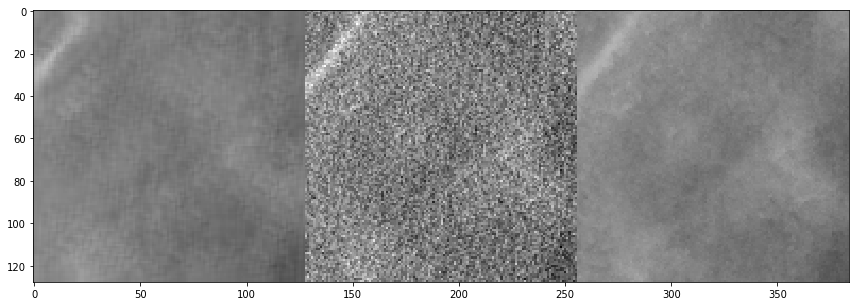

In [106]:
index = random.randint(0, len(output_result)-1)
plt.figure(figsize=(15,5))
plt.imshow(np.concatenate([output_result[index, 0, :, :], content_batch[index, 0, :, :], style_batch[index, 0, :, :]], axis=-1), cmap='gray')

In [3]:
def style_transfer(
        content=None,
        content_dir=None,
        content_size=512,
        style=None,
        style_dir=None,
        style_size=512,
        crop=None,
        preserve_color=None,
        alpha=1.0,
        style_interp_weights=None,
        mask=None,
        output_dir='output',
        save_ext='jpg',
        gpu=0,
        vgg_weights='models/vgg19_weights_normalized.h5',
        decoder_weights='models/decoder_weights.h5'):
    #assert bool(content) != bool(content_dir), 'Either content or content_dir should be given'
    #assert bool(style) != bool(style_dir), 'Either style or style_dir should be given'

    #if not os.path.exists(output_dir):
    #    print('Creating output dir at', output_dir)
    #    os.mkdir(output_dir)

    # Assume that it is either an h5 file or a name of a TensorFlow checkpoint
    decoder_in_h5 = False#"/home/pranjal/tf-adain/checkpoints/adain-240000"#decoder_weights.endswith('.h5')
    
    content_batch, style_batch = get_my_batch()
    
    print('Number of content images:', len(content_batch))
    print('Number of style images:', len(style_batch))

    data_format = 'channels_first'
    image, content, style, target, encoder, decoder = _build_graph(vgg_weights,
        decoder_weights if decoder_in_h5 else None, alpha, data_format=data_format)
    
    all_outputs = []
    #all_inputs 
    with tf.Session() as sess:
        if decoder_in_h5:
            sess.run(tf.global_variables_initializer())
        else:
            saver = tf.train.Saver()
            saver.restore(sess, decoder_weights)

        for k in range(len(content_batch)):
            content_image = content_batch[k]
            style_image   = style_batch[k]
            
            style_feature = sess.run(encoder, feed_dict={
                image: style_image[np.newaxis,:]
            })
            content_feature = sess.run(encoder, feed_dict={
                image: content_image[np.newaxis,:]
            })
            target_feature = sess.run(target, feed_dict={
                content: content_feature,
                style: style_feature
            })

            output = sess.run(decoder, feed_dict={
                content: content_feature,
                target: target_feature
            })
            
            all_outputs.append(output)
            #print("Output shape is ", output)
            
    return content_batch, style_batch, all_outputs

def _build_graph(vgg_weights, decoder_weights, alpha, data_format):
    if data_format == 'channels_first':
        image = tf.placeholder(shape=(None,3,None,None), dtype=tf.float32)
        content = tf.placeholder(shape=(1,512,None,None), dtype=tf.float32)
        style = tf.placeholder(shape=(1,512,None,None), dtype=tf.float32)
    else:
        image = tf.placeholder(shape=(None,None,None,3), dtype=tf.float32)
        content = tf.placeholder(shape=(1,None,None,512), dtype=tf.float32)
        style = tf.placeholder(shape=(1,None,None,512), dtype=tf.float32)

    target = adain(content, style, data_format=data_format)
    weighted_target = target * alpha + (1 - alpha) * content

    with open_weights(vgg_weights) as w:
        vgg = build_vgg(image, w, data_format=data_format)
        encoder = vgg['conv4_1']

    if decoder_weights:
        with open_weights(decoder_weights) as w:
            print(w)
            decoder = build_decoder(weighted_target, w, trainable=False,
                data_format=data_format)
    else:
        decoder = build_decoder(weighted_target, None, trainable=False,
            data_format=data_format)

    return image, content, style, target, encoder, decoder

In [ ]:
content_batch, style_batch, all_outputs = style_transfer()

all_outputs   = np.array(all_outputs)
content_batch = np.array(content_batch)
style_batch = np.array(style_batch)

print(all_outputs.shape, content_batch.shape, style_batch.shape)

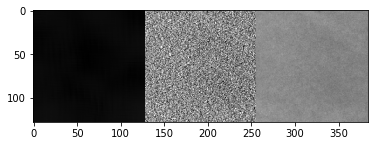

In [5]:
index = random.randint(0, len(all_outputs)-1)
plt.imshow(np.concatenate([all_outputs[index, 0, 0, :, :], content_batch[index, 0, :, :,], style_batch[index, 0, :, :,]], axis=-1), cmap='gray')

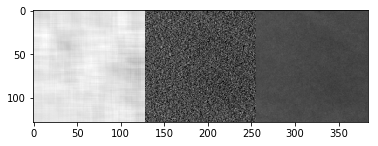

In [9]:
index = random.randint(0, len(all_outputs))
plt.imshow(np.concatenate([all_outputs[index, 0, 0, :, :], content_batch[index, 0, :, :,], style_batch[index, 0, :, :,]], axis=-1), cmap='gray')

6


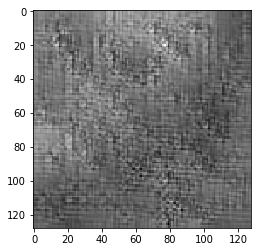

In [11]:
index = random.randint(0, len(all_outputs)-1)
print(index)
plt.imshow(all_outputs[index, 0, 0, :, :], cmap='gray')

In [31]:
index = random.randint(0, len(all_outputs)-1)
print(np.mean(all_outputs[index]), np.mean(content_batch[index]), np.mean(style_batch[index]))

0.071999006 0.0911 0.0911
